In [ ]:
!pip install scikeras


In [ ]:
# Install required packages
!pip install pydicom openpyxl pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.6 MB/s eta 0:00:00
   ━━━

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from google.colab import drive
from pycaret.classification import *
import pickle


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directory paths
output = '/content/drive/MyDrive/dataset INbreast/INbreast Release 1.0/INbreast Release 1.0'
removed_csv_path = '/content/drive/MyDrive/undersampled_removed_instances.csv'


In [ ]:
# Load features and labels
vgg_tr_ft_combined = np.load(os.path.join(output, 'new_vgg_tr_ft.npy'))
vgg_ts_ft = np.load(os.path.join(output, 'new_vgg_ts_ft.npy'))
tr_lbs_combined = np.load(os.path.join(output, 'tr_lbs.npy'))
ts_lbs = np.load(os.path.join(output, 'ts_lbs.npy'))


In [ ]:
vgg_tr_ft_combined.shape

(281, 1024)

In [ ]:
# Update label mappings
label_mapping = {1: 0, 2: 1, 4: 2, 5: 3}
tr_lbs_combined_mapped = np.vectorize(label_mapping.get)(tr_lbs_combined)
ts_lbs_mapped = np.vectorize(label_mapping.get)(ts_lbs)


Training Labels Distribution: {0: 51, 1: 157, 2: 31, 3: 42}
Test Labels Distribution: {0: 16, 1: 63, 2: 13, 3: 15}


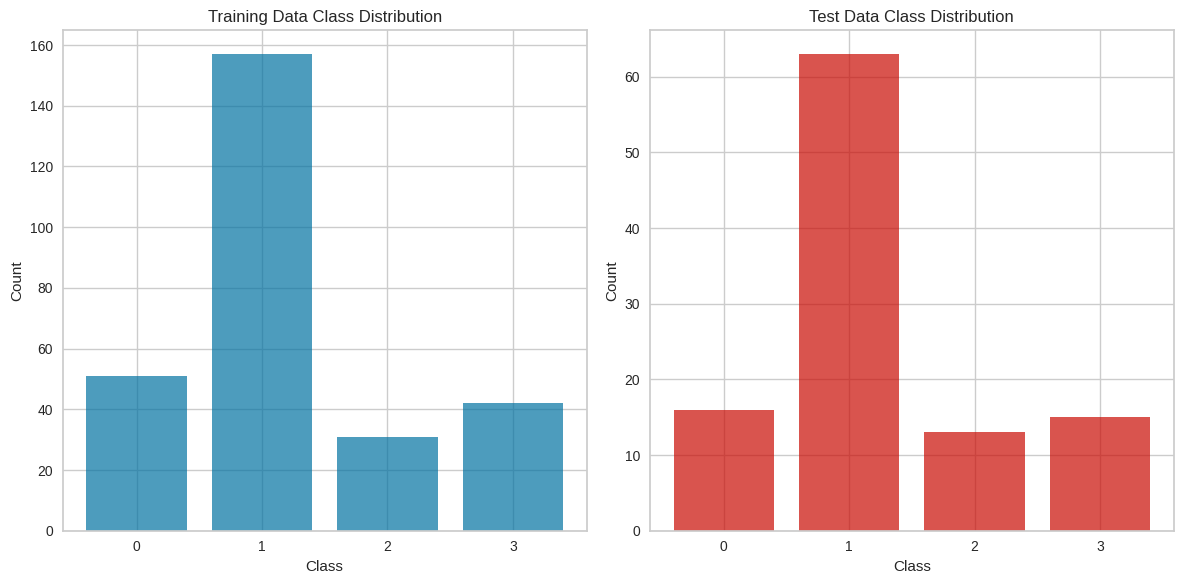

In [ ]:
# Display class distributions
unique_train, counts_train = np.unique(tr_lbs_combined_mapped, return_counts=True)
unique_test, counts_test = np.unique(ts_lbs_mapped, return_counts=True)
print("Training Labels Distribution:", dict(zip(unique_train, counts_train)))
print("Test Labels Distribution:", dict(zip(unique_test, counts_test)))

# Plot class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_train.astype(str), counts_train, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution')
plt.subplot(1, 2, 2)
plt.bar(unique_test.astype(str), counts_test, color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Data Class Distribution')
plt.tight_layout()
plt.show()


In [ ]:
# Prepare DataFrames
train_data = np.hstack((vgg_tr_ft_combined, tr_lbs_combined_mapped.reshape(-1, 1)))
test_data = np.hstack((vgg_ts_ft, ts_lbs_mapped.reshape(-1, 1)))
columns = [f'feature_{i}' for i in range(vgg_tr_ft_combined.shape[1])] + ['label']
df_train = pd.DataFrame(train_data, columns=columns)
df_test = pd.DataFrame(test_data, columns=columns)


In [ ]:
df_test
y_test_true = df_test['label']

In [ ]:
# Perform Random Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=123)
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Identify removed instances and save to CSV
df_train_undersampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
df_train_undersampled['label'] = y_train_resampled
df_removed = df_train[~df_train.index.isin(df_train_undersampled.index)]
df_removed.to_csv(removed_csv_path, index=False)
print("Data removed due to undersampling has been saved to:", removed_csv_path)


Data removed due to undersampling has been saved to: /content/drive/MyDrive/undersampled_removed_instances.csv


In [ ]:
X_train_resampled

### Result 48 percent accuarcy but overfitting!

In [ ]:
# Apply SMOTE for further balancing
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(df_train.drop('label', axis=1), df_train['label'])
df_train_smote = pd.DataFrame(X_train_smote, columns=df_train.drop('label', axis=1).columns)
df_train_smote['label'] = y_train_smote


In [ ]:
# Data Augmentation: Adding Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

augmented_data = add_gaussian_noise(df_train_smote.drop('label', axis=1))
augmented_df = pd.DataFrame(augmented_data, columns=df_train_smote.drop('label', axis=1).columns)
augmented_df['label'] = df_train_smote['label'].values
df_train_augmented = pd.concat([df_train_smote, augmented_df])

print("Class distribution after augmentation:", df_train_augmented['label'].value_counts())
print("Final Balanced Training Data Shape:", df_train_augmented.shape)
print("Testing Data Shape:", df_test.shape)


Class distribution after augmentation: label
0.0    62
1.0    62
2.0    62
3.0    62
Name: count, dtype: int64
Final Balanced Training Data Shape: (248, 1025)
Testing Data Shape: (107, 1025)


In [ ]:
# Setup PyCaret
clf_setup = setup(data=df_train_augmented, target='label', session_id=123, verbose=True, index=False, train_size=0.8)


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(2512, 1025)"
4,Transformed data shape,"(2512, 1025)"
5,Transformed train set shape,"(2009, 1025)"
6,Transformed test set shape,"(503, 1025)"
7,Numeric features,1024
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# Model selection and evaluation
best_model = compare_models()
print(f"Best Model: {best_model}")
final_model = finalize_model(best_model)

# Save the finalized model
model_path = '/content/drive/MyDrive/final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)
print("Final model has been saved to:", model_path)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9522,0.9959,0.9522,0.9553,0.9510,0.9209,0.9235,78.0840
xgboost,Extreme Gradient Boosting,0.9489,0.9956,0.9489,0.9524,0.9475,0.9150,0.9182,18.6990
et,Extra Trees Classifier,0.9366,0.9938,0.9366,0.9426,0.9344,0.8938,0.8988,0.9000
gbc,Gradient Boosting Classifier,0.9277,0.0000,0.9277,0.9340,0.9254,0.8785,0.8841,76.2170
rf,Random Forest Classifier,0.9244,0.9903,0.9244,0.9325,0.9222,0.8724,0.8790,2.4030
dt,Decision Tree Classifier,0.8932,0.9222,0.8932,0.8997,0.8937,0.8303,0.8322,1.4470
qda,Quadratic Discriminant Analysis,0.8253,0.0000,0.8253,0.9193,0.8445,0.7480,0.7773,0.3190
lda,Linear Discriminant Analysis,0.7675,0.0000,0.7675,0.7798,0.7700,0.6359,0.6388,0.3480
knn,K Neighbors Classifier,0.7597,0.9044,0.7597,0.7755,0.7514,0.5970,0.6044,0.2570
ridge,Ridge Classifier,0.6441,0.0000,0.6441,0.6745,0.5765,0.2847,0.3559,0.3860


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Best Model: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Final model has been saved to: /content/drive/MyDrive/final_model_without_smote.pkl


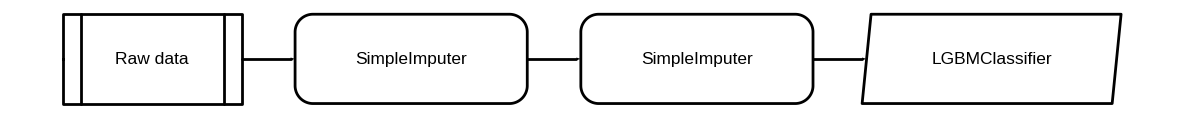

In [ ]:
# Evaluate the model
evaluate_model(final_model)


In [ ]:
final_model = load_model(r'/content/drive/MyDrive/final_model')


Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Predictions on training and test data
df_train_augmented = df_train_augmented.reset_index(drop=True)
train_predictions = predict_model(final_model, data=df_train_augmented)
test_predictions = predict_model(final_model, data=df_test)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.4673,0.5606,0.4673,0.4410,0.4466,0.0506,0.0514


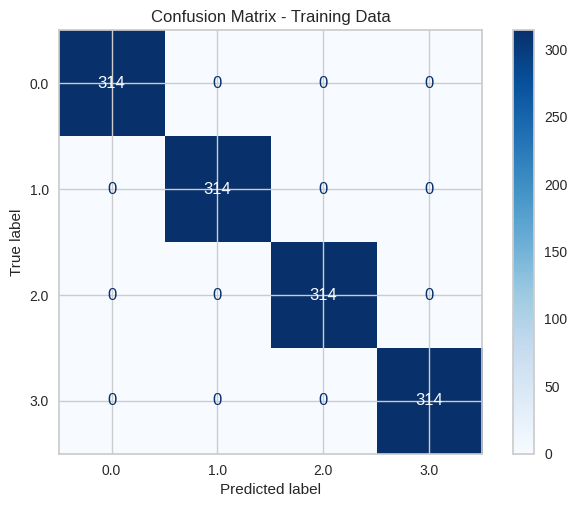

In [ ]:
# Confusion matrix for training data
y_train_true = df_train_augmented['label']
y_train_pred = train_predictions['Label'] if 'Label' in train_predictions.columns else train_predictions['label']
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=sorted(df_train_augmented['label'].unique()))
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Training Data")
plt.show()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


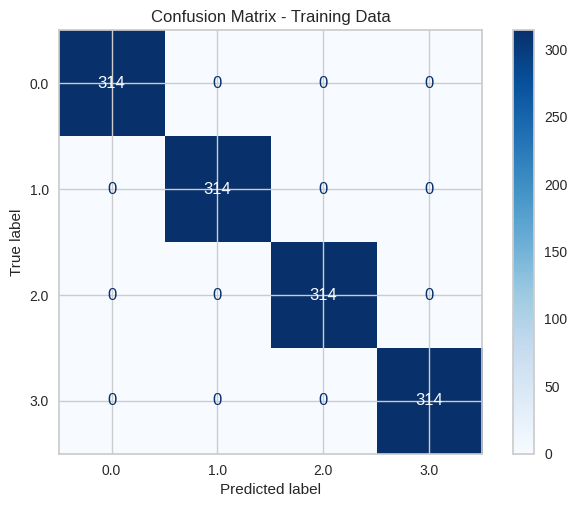

In [ ]:
# Ensure predictions are aligned correctly with the training data
train_predictions = predict_model(final_model, data=df_train_augmented)
y_train_true = df_train_augmented['label']  # True labels for the training data

# Use the correct column name based on the output format from PyCaret's predict_model
if 'Label' in train_predictions.columns:
    y_train_pred = train_predictions['Label']
else:
    y_train_pred = train_predictions['label']

# Check if lengths match
if len(y_train_true) == len(y_train_pred):
    # Calculate and plot the confusion matrix for training data
    cm_train = confusion_matrix(y_train_true, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=sorted(df_train_augmented['label'].unique()))
    disp_train.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Training Data")
    plt.show()
else:
    print("Mismatch in lengths between true labels and predicted labels for training data.")


In [ ]:
test_predictions

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023,label,prediction_label,prediction_score
0,0.182005,0.342565,0.0,0.0,0.0,0.408282,0.182009,0.0,0.432615,0.0,...,0.0,0.622495,0.000000,0.432632,0.256246,0.011431,0.113362,1.0,0,0.37
1,0.269087,0.442765,0.0,0.0,0.0,0.308442,0.132020,0.0,0.436940,0.0,...,0.0,0.605874,0.000000,0.408433,0.319609,0.024993,0.014476,1.0,1,0.46
2,0.272385,0.452032,0.0,0.0,0.0,0.297535,0.199034,0.0,0.428009,0.0,...,0.0,0.562665,0.000000,0.438465,0.372109,0.053137,0.087946,2.0,1,0.49
3,0.245103,0.428220,0.0,0.0,0.0,0.390765,0.152833,0.0,0.391258,0.0,...,0.0,0.638765,0.000000,0.337723,0.295085,0.029827,0.000000,3.0,1,0.61
4,0.277481,0.471078,0.0,0.0,0.0,0.337939,0.171912,0.0,0.443043,0.0,...,0.0,0.595934,0.000000,0.390653,0.314653,0.083432,0.021654,0.0,1,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.238148,0.414690,0.0,0.0,0.0,0.413844,0.197791,0.0,0.470861,0.0,...,0.0,0.573991,0.007985,0.398055,0.339392,0.078029,0.087465,0.0,3,0.35
103,0.194009,0.431488,0.0,0.0,0.0,0.413990,0.171353,0.0,0.422794,0.0,...,0.0,0.604316,0.000000,0.403191,0.328650,0.068060,0.090049,3.0,3,0.44
104,0.263054,0.431373,0.0,0.0,0.0,0.358248,0.195846,0.0,0.422897,0.0,...,0.0,0.579381,0.000000,0.435109,0.322138,0.062221,0.063121,1.0,1,0.52
105,0.280708,0.394028,0.0,0.0,0.0,0.376589,0.146901,0.0,0.448070,0.0,...,0.0,0.640459,0.000000,0.433270,0.310514,0.024630,0.041637,0.0,3,0.37


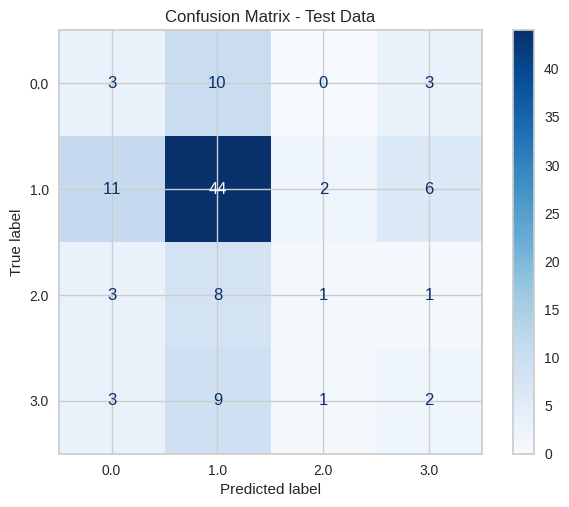

In [ ]:
# Confusion matrix for test data
# y_test_true = df_test['label']
y_test_pred = test_predictions['prediction_label'] if 'prediction_label' in test_predictions.columns else test_predictions['prediction_label']
cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=sorted(df_test['label'].unique()))
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()


### Result 31 percent accuarcy  using Undersampling and SMOTE  and Data aug. together

In [ ]:
# Apply SMOTE for further balancing
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(df_train_undersampled.drop('label', axis=1), df_train_undersampled['label'])
df_train_smote = pd.DataFrame(X_train_smote, columns=df_train_undersampled.drop('label', axis=1).columns)
df_train_smote['label'] = y_train_smote


Training Labels Distribution: {0.0: 31, 1.0: 31, 2.0: 31, 3.0: 31}
Test Labels Distribution: {0.0: 31, 1.0: 31, 2.0: 31, 3.0: 31}


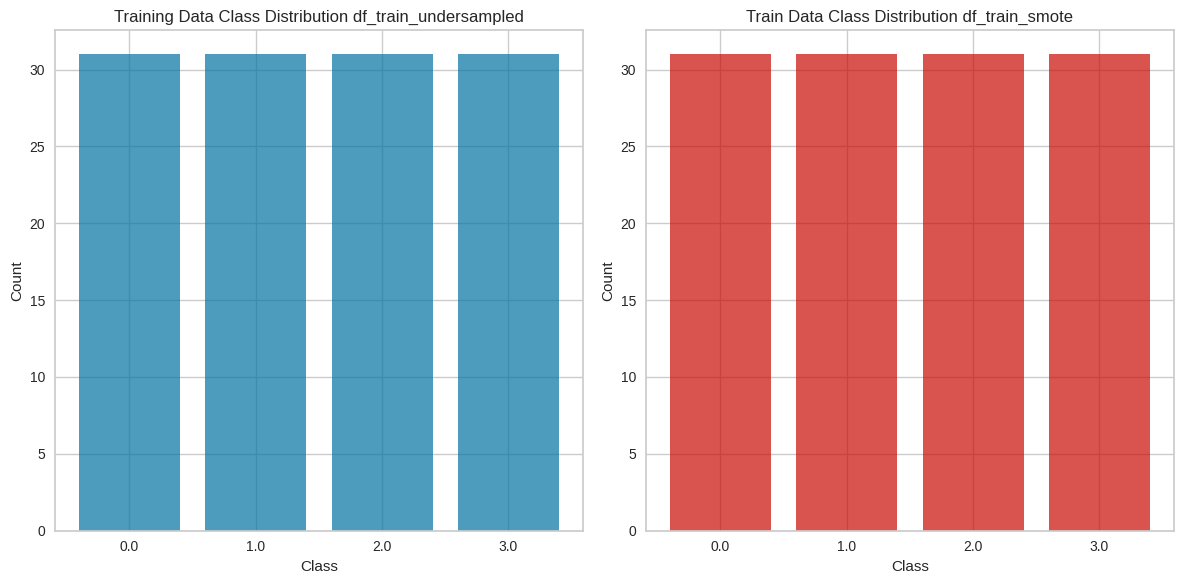

In [ ]:
# Display class distributions
unique_train, counts_train = np.unique(df_train_undersampled['label'], return_counts=True)
unique_test, counts_test = np.unique(df_train_smote['label'], return_counts=True)
print("Training Labels Distribution:", dict(zip(unique_train, counts_train)))
print("Test Labels Distribution:", dict(zip(unique_test, counts_test)))

# Plot class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_train.astype(str), counts_train, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution df_train_undersampled')
plt.subplot(1, 2, 2)
plt.bar(unique_test.astype(str), counts_test, color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Data Class Distribution df_train_smote')
plt.tight_layout()
plt.show()


In [ ]:
# Data Augmentation: Adding Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

augmented_data = add_gaussian_noise(df_train_smote.drop('label', axis=1))
augmented_df = pd.DataFrame(augmented_data, columns=df_train_smote.drop('label', axis=1).columns)
augmented_df['label'] = df_train_smote['label'].values
df_train_augmented = pd.concat([df_train_smote, augmented_df])

print("Class distribution after augmentation:", df_train_augmented['label'].value_counts())
print("Final Balanced Training Data Shape:", df_train_augmented.shape)
print("Testing Data Shape:", df_test.shape)


Class distribution after augmentation: label
0.0    62
1.0    62
2.0    62
3.0    62
Name: count, dtype: int64
Final Balanced Training Data Shape: (248, 1025)
Testing Data Shape: (107, 1025)


In [ ]:
# Setup PyCaret
clf_setup = setup(data=df_train_augmented, target='label', session_id=123, verbose=True, index=False, train_size=0.8)


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(496, 1025)"
4,Transformed data shape,"(496, 1025)"
5,Transformed train set shape,"(396, 1025)"
6,Transformed test set shape,"(100, 1025)"
7,Numeric features,1024
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# Model selection and evaluation
best_model = compare_models()
print(f"Best Model: {best_model}")
final_model = finalize_model(best_model)

# Save the finalized model
model_path = '/content/drive/MyDrive/final_model_undersampled.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)
print("Final model has been saved to:", model_path)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9592,0.9968,0.9592,0.9643,0.9594,0.9456,0.9472,0.4220
gbc,Gradient Boosting Classifier,0.9519,0.0000,0.9519,0.9564,0.9514,0.9358,0.9376,31.0920
qda,Quadratic Discriminant Analysis,0.9491,0.0000,0.9491,0.9582,0.9494,0.9321,0.9351,0.1250
lightgbm,Light Gradient Boosting Machine,0.9417,0.9969,0.9417,0.9493,0.9418,0.9223,0.9248,20.5760
rf,Random Forest Classifier,0.9416,0.9949,0.9416,0.9481,0.9418,0.9221,0.9242,0.8920
xgboost,Extreme Gradient Boosting,0.9365,0.9953,0.9365,0.9462,0.9354,0.9152,0.9188,9.3250
dt,Decision Tree Classifier,0.8785,0.9191,0.8785,0.8915,0.8767,0.8381,0.8428,0.2620
ridge,Ridge Classifier,0.7797,0.0000,0.7797,0.8007,0.7795,0.7063,0.7125,0.1150
lda,Linear Discriminant Analysis,0.7369,0.0000,0.7369,0.7521,0.7356,0.6493,0.6540,0.2480
knn,K Neighbors Classifier,0.6614,0.8899,0.6614,0.6827,0.6558,0.5478,0.5553,0.0980


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Best Model: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
Final model has been saved to: /content/drive/MyDrive/final_model_undersampled.pkl


In [ ]:
# Evaluate the model
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.classification import load_model, save_model

# Load the PyCaret model from the .pkl file
loaded_model = load_model('/content/drive/MyDrive/final_model')

# Save the loaded model as a .h5 file
save_model(loaded_model, '/content/drive/MyDrive/final_model.h5')

Transformation Pipeline and Model Successfully Loaded


ValueError: _CURRENT_EXPERIMENT global variable is not set. Please run setup() first.

In [ ]:
keras_model = loaded_model.get_model()
keras_model.save('my_model.h5')

AttributeError: 'ExtraTreesClassifier' object has no attribute 'get_model'

In [ ]:
# Load the PyCaret model from the .pkl file
loaded_model = load_model('/content/drive/MyDrive/final_model')
loaded_model.get_params()

{'memory': Memory(location=None),
 'steps': [('numerical_imputer',
   TransformerWrapper(include=['feature_0', 'feature_1', 'feature_2', 'feature_3',
                               'feature_4', 'feature_5', 'feature_6', 'feature_7',
                               'feature_8', 'feature_9', 'feature_10',
                               'feature_11', 'feature_12', 'feature_13',
                               'feature_14', 'feature_15', 'feature_16',
                               'feature_17', 'feature_18', 'feature_19',
                               'feature_20', 'feature_21', 'feature_22',
                               'feature_23', 'feature_24', 'feature_25',
                               'feature_26', 'feature_27', 'feature_28',
                               'feature_29', ...],
                      transformer=SimpleImputer())),
  ('categorical_imputer',
   TransformerWrapper(include=[],
                      transformer=SimpleImputer(strategy='most_frequent'))),
  ('actual_estima

In [ ]:
# Predictions on training and test data
df_train_augmented = df_train_augmented.reset_index(drop=True)
train_predictions = predict_model(final_model, data=df_train_augmented)
test_predictions = predict_model(final_model, data=df_test)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.3364,0.5979,0.3364,0.5491,0.3657,0.1278,0.1460


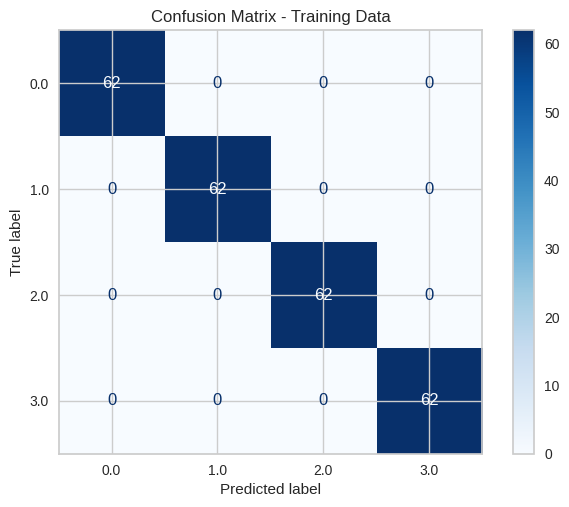

In [ ]:
# Confusion matrix for training data
y_train_true = df_train_augmented['label']
y_train_pred = train_predictions['Label'] if 'Label' in train_predictions.columns else train_predictions['label']
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=sorted(df_train_augmented['label'].unique()))
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Training Data")
plt.show()


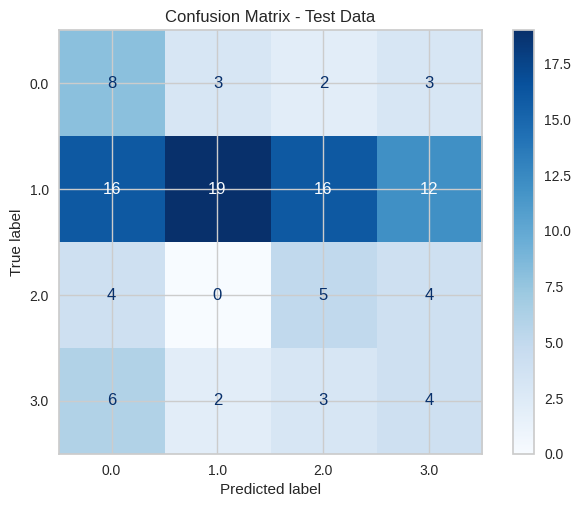

In [ ]:
# Confusion matrix for test data
# y_test_true = df_test['label']
y_test_pred = test_predictions['prediction_label'] if 'prediction_label' in test_predictions.columns else test_predictions['prediction_label']
cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=sorted(df_test['label'].unique()))
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()


In [ ]:
#@title New Undersampling but no SMOTE + data aug.

In [ ]:
# Data Augmentation: Adding Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

augmented_data = add_gaussian_noise(df_train_undersampled.drop('label', axis=1))
augmented_df = pd.DataFrame(augmented_data, columns=df_train_undersampled.drop('label', axis=1).columns)
augmented_df['label'] = df_train_undersampled['label'].values
df_train_augmented2 = pd.concat([df_train_undersampled, augmented_df])

print("Class distribution after augmentation:", df_train_augmented2['label'].value_counts())
print("Final Balanced Training Data Shape:", df_train_augmented2.shape)
print("Testing Data Shape:", df_test.shape)


Class distribution after augmentation: label
0.0    62
1.0    62
2.0    62
3.0    62
Name: count, dtype: int64
Final Balanced Training Data Shape: (248, 1025)
Testing Data Shape: (107, 1025)


Training Labels Distribution: {0.0: 62, 1.0: 62, 2.0: 62, 3.0: 62}
Test Labels Distribution: {0.0: 16, 1.0: 63, 2.0: 13, 3.0: 15}


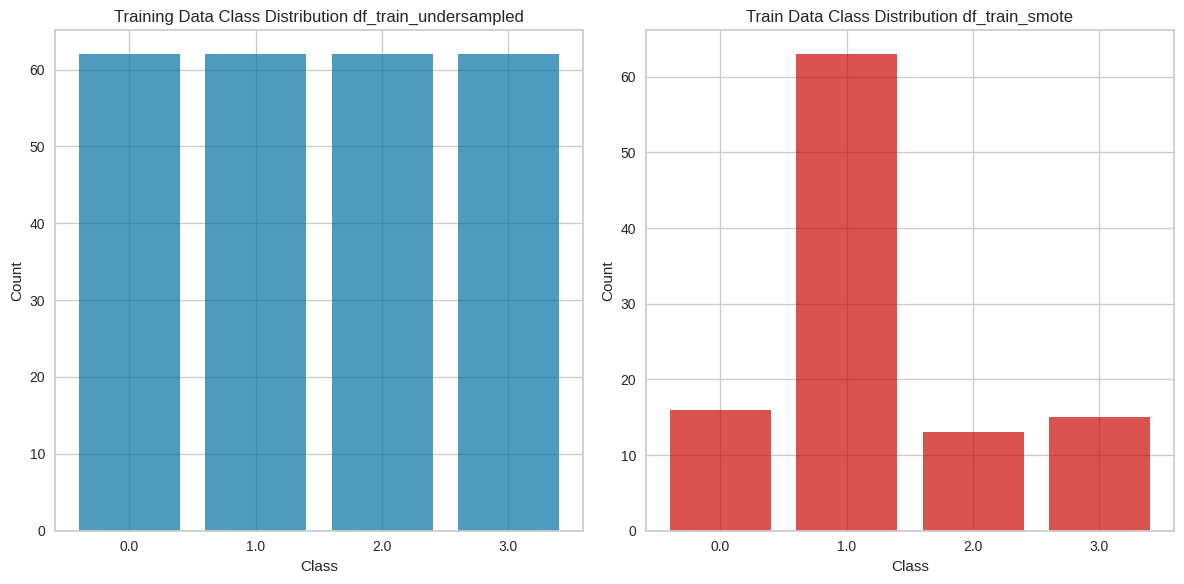

In [ ]:
# Display class distributions
unique_train, counts_train = np.unique(df_train_augmented2['label'], return_counts=True)
unique_test, counts_test = np.unique(df_test['label'], return_counts=True)
print("Training Labels Distribution:", dict(zip(unique_train, counts_train)))
print("Test Labels Distribution:", dict(zip(unique_test, counts_test)))

# Plot class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_train.astype(str), counts_train, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution df_train_undersampled')
plt.subplot(1, 2, 2)
plt.bar(unique_test.astype(str), counts_test, color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Data Class Distribution df_train_smote')
plt.tight_layout()
plt.show()


In [ ]:
# Setup PyCaret
clf_setup = setup(data=df_train_augmented2, target='label', session_id=123, verbose=True, index=False, train_size= 0.9)


,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(248, 1025)"
4,Transformed data shape,"(248, 1025)"
5,Transformed train set shape,"(223, 1025)"
6,Transformed test set shape,"(25, 1025)"
7,Numeric features,1024
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# Model selection and evaluation
best_model = compare_models()
print(f"Best Model: {best_model}")
final_model = finalize_model(best_model)

# Save the finalized model
model_path = '/content/drive/MyDrive/final_model_undersampled_aug.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)
print("Final model has been saved to:", model_path)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7941,0.9422,0.7941,0.8260,0.7908,0.7253,0.7344,0.6560
lightgbm,Light Gradient Boosting Machine,0.7626,0.9197,0.7626,0.7843,0.7562,0.6826,0.6916,11.4080
rf,Random Forest Classifier,0.7587,0.9054,0.7587,0.7891,0.7556,0.6779,0.6881,0.5020
xgboost,Extreme Gradient Boosting,0.7534,0.9076,0.7534,0.7838,0.7512,0.6709,0.6798,8.9470
gbc,Gradient Boosting Classifier,0.7267,0.0000,0.7267,0.7487,0.7238,0.6346,0.6419,24.4470
dt,Decision Tree Classifier,0.5518,0.6995,0.5518,0.5776,0.5363,0.4010,0.4116,0.3690
ridge,Ridge Classifier,0.5291,0.0000,0.5291,0.5465,0.5161,0.3711,0.3824,0.0840
lda,Linear Discriminant Analysis,0.4891,0.0000,0.4891,0.5075,0.4769,0.3191,0.3267,0.2600
ada,Ada Boost Classifier,0.4532,0.0000,0.4532,0.4648,0.4268,0.2689,0.2805,1.6560
knn,K Neighbors Classifier,0.4304,0.7103,0.4304,0.4468,0.4238,0.2393,0.2448,0.1590


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Best Model: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
Final model has been saved to: /content/drive/MyDrive/final_model_undersampled_aug.pkl


In [ ]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# Predictions on training and test data
df_train_augmented2 = df_train_augmented2.reset_index(drop=True)
train_predictions = predict_model(final_model, data=df_train_augmented2)
test_predictions = predict_model(final_model, data=df_test)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.2991,0.6087,0.2991,0.4960,0.3356,0.0691,0.0783


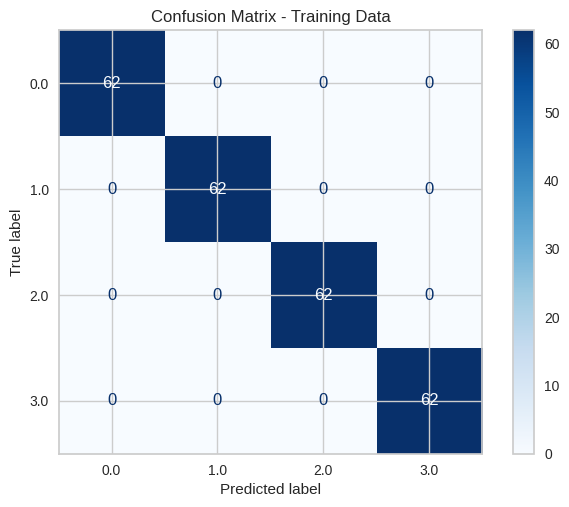

In [ ]:
# Confusion matrix for training data
y_train_true = df_train_augmented2['label']
y_train_pred = train_predictions['Label'] if 'Label' in train_predictions.columns else train_predictions['label']
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=sorted(df_train_augmented2['label'].unique()))
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Training Data")
plt.show()


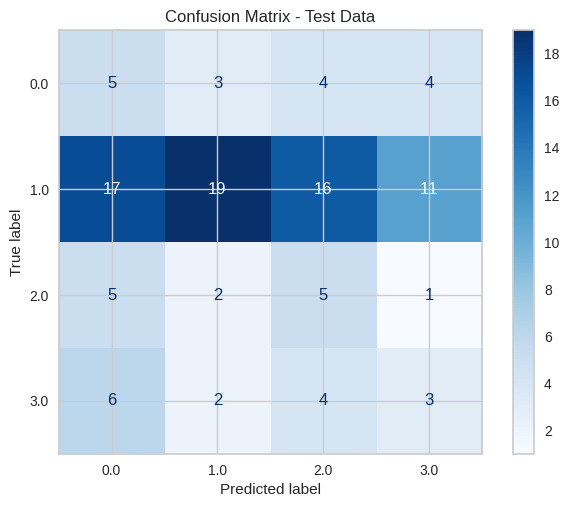

In [ ]:
# Confusion matrix for test data
# y_test_true = df_test['label']
y_test_pred = test_predictions['prediction_label'] if 'prediction_label' in test_predictions.columns else test_predictions['prediction_label']
cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=sorted(df_test['label'].unique()))
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()


In [ ]:
#@title Trying to increase complexity !!

In [ ]:
# Apply SMOTE for further balancing
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(df_train.drop('label', axis=1), df_train['label'])
df_train_smote = pd.DataFrame(X_train_smote, columns=df_train.drop('label', axis=1).columns)
df_train_smote['label'] = y_train_smote


In [ ]:
# Data Augmentation: Adding Gaussian noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

augmented_data = add_gaussian_noise(df_train_smote.drop('label', axis=1))
augmented_df = pd.DataFrame(augmented_data, columns=df_train_smote.drop('label', axis=1).columns)
augmented_df['label'] = df_train_smote['label'].values
df_train_augmented3 = pd.concat([df_train_smote, augmented_df])

print("Class distribution after augmentation:", df_train_augmented3['label'].value_counts())
print("Final Balanced Training Data Shape:", df_train_augmented3.shape)
print("Testing Data Shape:", df_test.shape)


Class distribution after augmentation: label
1.0    314
0.0    314
3.0    314
2.0    314
Name: count, dtype: int64
Final Balanced Training Data Shape: (1256, 1025)
Testing Data Shape: (107, 1025)


In [ ]:
import numpy as np
import pandas as pd

# Data Augmentation: Adding Gaussian Noise
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

# Data Augmentation: Scaling
def scale_features(X, scaling_factor=1.2):
    return X * scaling_factor

# Data Augmentation: Random Flipping (simulates feature flipping if applicable)
def random_flip(X):
    return np.flip(X.values, axis=1)

# Data Augmentation: Random Rotation (simulates feature shifts)
def random_rotation(X, max_shift=2):
    return np.roll(X.values, shift=np.random.randint(-max_shift, max_shift), axis=1)

# Original data
X_train = df_train_smote.drop('label', axis=1)
y_train = df_train_smote['label']

# Augmentations
augmented_data_list = []

# Apply Gaussian noise multiple times with varying intensities
for std in [0.01,0.03,0.05,0.07,0.1]:
    augmented_data = add_gaussian_noise(X_train, std=std)
    augmented_data_list.append(pd.DataFrame(augmented_data, columns=X_train.columns))

# Apply scaling
for scaling_factor in [0.8,0.9,1.0,1.1,1.2]:
    scaled_data = scale_features(X_train, scaling_factor)
    augmented_data_list.append(pd.DataFrame(scaled_data, columns=X_train.columns))

# Apply random flipping
flipped_data = random_flip(X_train)
augmented_data_list.append(pd.DataFrame(flipped_data, columns=X_train.columns))

# Apply random rotation
rotated_data = random_rotation(X_train)
augmented_data_list.append(pd.DataFrame(rotated_data, columns=X_train.columns))

# Combine all augmented data
augmented_df_list = [df.assign(label=y_train.values) for df in augmented_data_list]
augmented_df = pd.concat(augmented_df_list, ignore_index=True)

# Merge with original data
df_train_augmented3 = pd.concat([df_train_smote, augmented_df])

# Final outputs
print("Class distribution after augmentation:", df_train_augmented3['label'].value_counts())
print("Final Balanced Training Data Shape:", df_train_augmented3.shape)
print("Testing Data Shape:", df_test.shape)


Class distribution after augmentation: label
1.0    2041
0.0    2041
3.0    2041
2.0    2041
Name: count, dtype: int64
Final Balanced Training Data Shape: (8164, 1025)
Testing Data Shape: (107, 1025)


Training Labels Distribution: {0.0: 2041, 1.0: 2041, 2.0: 2041, 3.0: 2041}
Test Labels Distribution: {0.0: 16, 1.0: 63, 2.0: 13, 3.0: 15}


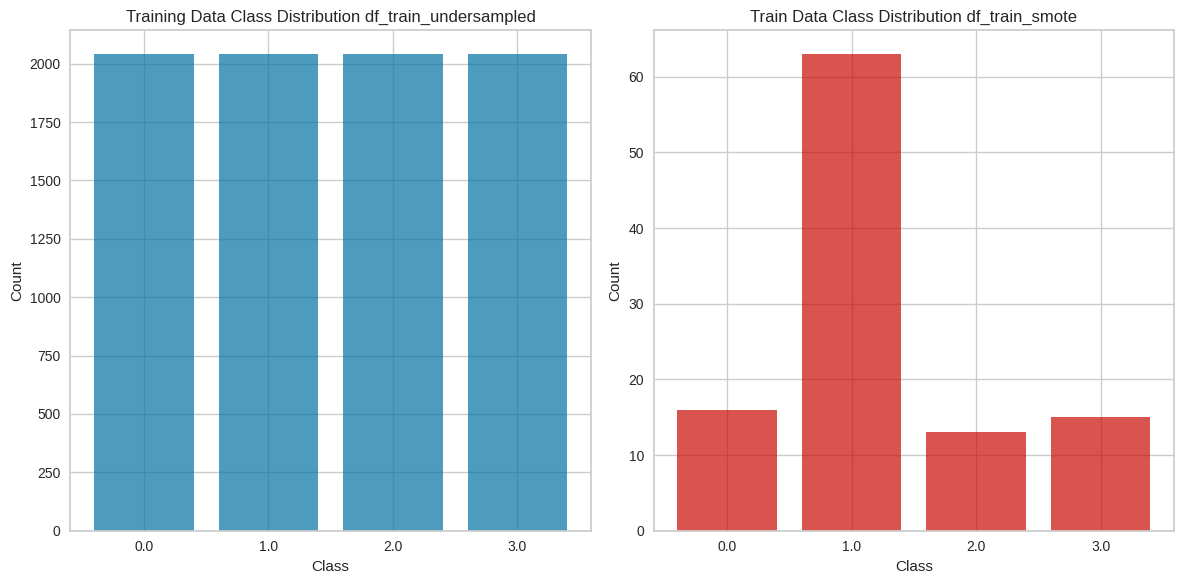

In [ ]:
# Display class distributions
unique_train, counts_train = np.unique(df_train_augmented3['label'], return_counts=True)
unique_test, counts_test = np.unique(df_test['label'], return_counts=True)
print("Training Labels Distribution:", dict(zip(unique_train, counts_train)))
print("Test Labels Distribution:", dict(zip(unique_test, counts_test)))

# Plot class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_train.astype(str), counts_train, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution df_train_undersampled')
plt.subplot(1, 2, 2)
plt.bar(unique_test.astype(str), counts_test, color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Data Class Distribution df_train_smote')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Step 1: Preprocess Data
# Separate features and labels
X = df_train_augmented3.drop('label', axis=1).values
y = df_train_augmented3['label'].values

# Encode labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# # Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Test set processing
X_test = df_test.drop('label', axis=1).values
y_test = label_encoder.transform(df_test['label'].values)
# X_test = scaler.transform(X_test)


In [ ]:
y_test

array([1, 1, 2, 3, 0, 3, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 2,
       3, 0, 1, 1, 1, 2, 0, 1, 3, 1, 2, 1, 3, 3, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1, 3, 3, 0, 0, 0, 1, 1, 2,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 1])

In [ ]:
y_train.size

7347

In [ ]:
from tensorflow.keras import layers, models

# Define CNN architecture for 1D input
model = models.Sequential([
    layers.Reshape((1024, 1), input_shape=(1024,)),  # Reshape to 1D with a single channel
    layers.Conv1D(32, kernel_size=3, activation='relu'),  # 1D Convolution
    layers.MaxPooling1D(pool_size=2),  # 1D Max Pooling
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer
])

# Model Summary
model.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_18 (Reshape)                 │ (None, 1024, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ (None, 1022, 32)            │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 511, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 509, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 254, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 16256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 128)                 │       2,080,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,087,748 (7.96 MB)

 Trainable params: 2,087,748 (7.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),  # Reduced dropout rate
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])


In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),  # Reduced dropout rate
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])


In [ ]:
model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])


In [ ]:
# Class weights based on the confusion matrix and misclassification rates
class_weights = {0: 1.0, 1: 0.5, 2: 1.0, 3: 1.0}

# Define your model
model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),  # Reduced dropout rate
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

In [ ]:
#@title gives 41 percent with no overfitting !

model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),  # Reduced dropout rate
    layers.Dense(512, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,508 (3.01 MB)

 Trainable params: 789,508 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title with 128, 0.005 - 39% with no over fitting!

model = models.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),  # Reduced dropout rate
    # layers.Dense(512, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
])

model.summary()

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_211 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_212 (Dense)                    │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,852 (2.01 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_211 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_212 (Dense)                    │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,852 (2.01 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2647 - loss: 1.4529 - val_accuracy: 0.3586 - val_loss: 1.3630
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3341 - loss: 1.3528 - val_accuracy: 0.3611 - val_loss: 1.3505
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3590 - loss: 1.3396 - val_accuracy: 0.3660 - val_loss: 1.3315
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4075 - loss: 1.2866 - val_accuracy: 0.4002 - val_loss: 1.2723
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4354 - loss: 1.2504 - val_accuracy: 0.4639 - val_loss: 1.2303
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4379 - loss: 1.2278 - val_accuracy: 0.4639 - val_loss: 1.2169
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4498 - loss: 1.1968 - val_accuracy: 0.4982 - val_loss: 1.1873
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4772 - loss: 1.1735 - val_

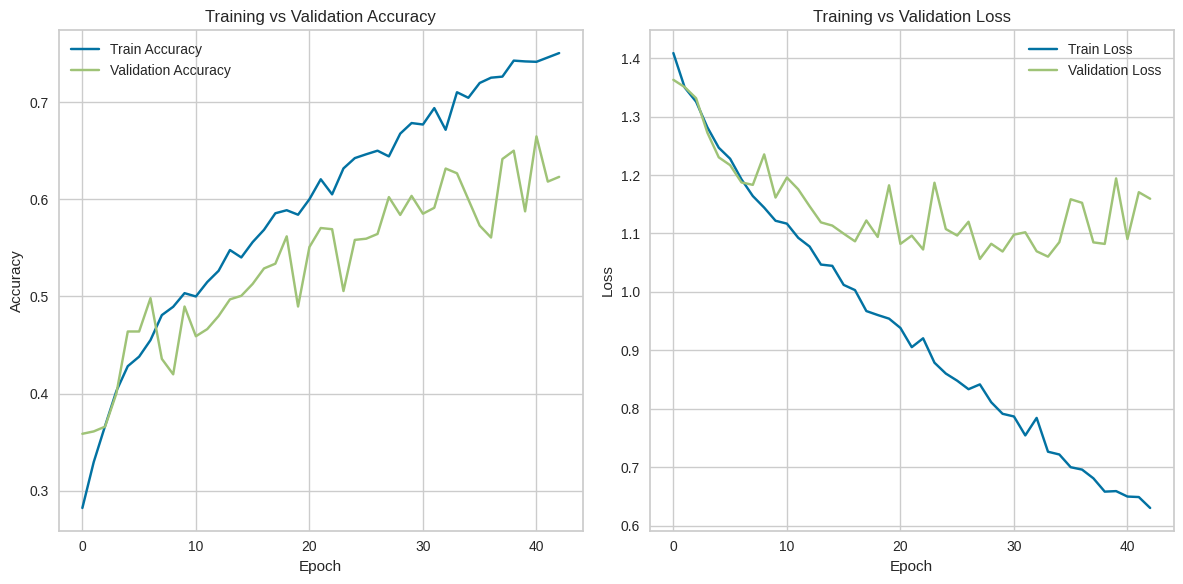

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Step 3: Compile and Train Model

model.summary()

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience= 15, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # Add EarlyStopping callback
    # class_weight=class_weights  # Applying the class weights
)

# Plot training history for Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot training history for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Step 4: Evaluate on Test Set
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Accuracy: 0.37383177570093457
Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.06      0.06        16
           1       0.64      0.51      0.57        63
           2       0.16      0.23      0.19        13
           3       0.18      0.27      0.22        15

    accuracy                           0.37       107
   macro avg       0.26      0.27      0.26       107
weighted avg       0.43      0.37      0.40       107



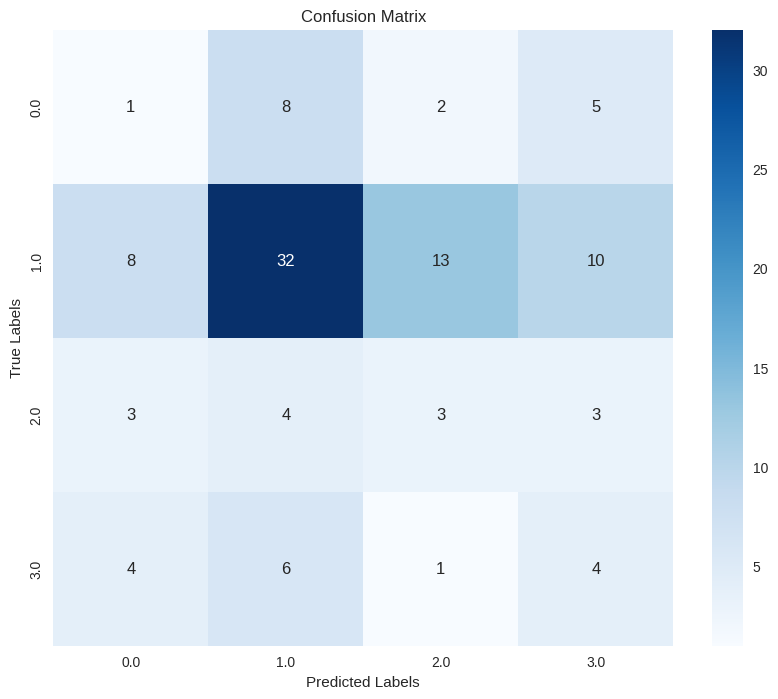

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
conf_matrix

array([[ 9,  4,  0,  3],
       [16, 20, 13, 14],
       [ 4,  1,  5,  3],
       [ 5,  4,  4,  2]])

In [ ]:
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import numpy as np

# Step 1: Define the model creation function
def create_model(learning_rate=0.001):
    model = models.Sequential([
        layers.InputLayer(input_shape=X_train.shape[1:]),  # Input layer
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),  # Reduced dropout rate
        layers.Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Step 2: Create a KerasClassifier
model = KerasClassifier(
    model=create_model,
    verbose=0
)

# Step 3: Define the parameter grid for GridSearchCV
param_grid = {
    'model__learning_rate': [0.0001, 0.0005, 0.001],  # 'model__' prefix for model parameters
    'batch_size': [64, 128],  # Testing your optimal batch size
    'epochs': [50, 100]  # Fewer epochs to prevent overfitting
}

# Step 4: Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Perform GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3  # 3-fold cross-validation
)

# Assuming X_train, y_train, X_val, and y_val are already defined
grid_result = grid.fit(
    X_train,
    y_train,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

# Step 6: Output the best parameters and scores
print("Best parameters found: ", grid_result.best_params_)
print("Best cross-validation accuracy: ", grid_result.best_score_)


Best parameters found:  {'batch_size': 64, 'epochs': 100, 'model__learning_rate': 0.001}
Best cross-validation accuracy:  0.6636722471757179


In [ ]:
# Step 7: Save the best model
best_model = grid_result.best_estimator_.model_  # Access the underlying Keras model
best_model.save('66_CNN_AIHC.h5')

print("Best model saved as 'best_model.h5'.")


Best model saved as 'best_model.h5'.


In [ ]:
# Step 4: Evaluate on Test Set
y_pred = np.argmax(best_model.predict(X_test), axis=1)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test Accuracy: 0.42990654205607476
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.25      0.20        16
           1       0.69      0.56      0.61        63
           2       0.21      0.23      0.22        13
           3       0.24      0.27      0.25        15

    accuracy                           0.43       107
   macro avg       0.32      0.33      0.32       107
weighted avg       0.49      0.43      0.45       107



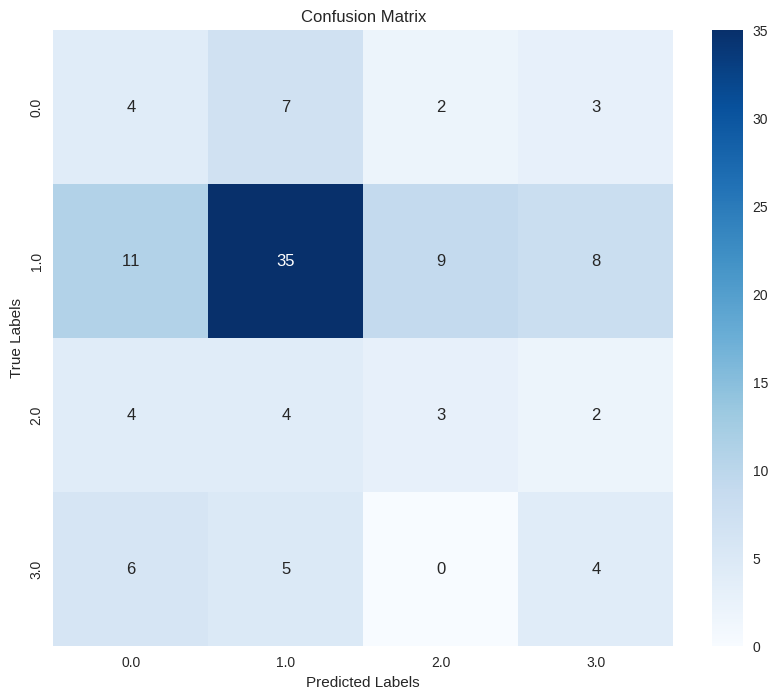

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('cnn_AIHC.h5')
print("Model loaded successfully!")

In [ ]:
#@title Lishen's way but for multiple BIRADs

In [ ]:
# Apply SMOTE for further balancing
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(df_train.drop('label', axis=1), df_train['label'])
df_train_smote = pd.DataFrame(X_train_smote, columns=df_train.drop('label', axis=1).columns)
df_train_smote['label'] = y_train_smote


In [ ]:
# Display class distributions
unique_train, counts_train = np.unique(df_train_augmented3['label'], return_counts=True)
unique_test, counts_test = np.unique(df_test['label'], return_counts=True)
print("Training Labels Distribution:", dict(zip(unique_train, counts_train)))
print("Test Labels Distribution:", dict(zip(unique_test, counts_test)))

# Plot class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(unique_train.astype(str), counts_train, color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Class Distribution df_train_SMOTE_Gaussian')
plt.subplot(1, 2, 2)
plt.bar(unique_test.astype(str), counts_test, color='r', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Train Data Class Distribution df_test')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Step 1: Preprocess Data
# Separate features and labels
X = df_train_augmented2.drop('label', axis=1).values
y = df_train_augmented2['label'].values

# Encode labels if they are categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# # Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Test set processing
X_test = df_test.drop('label', axis=1).values
y_test = label_encoder.transform(df_test['label'].values)
# X_test = scaler.transform(X_test)
